# Predictive Modeling for Library Migration

## Hypothesis

* H1: If many other projects have removed a library, it will be more likely for a project to migrate away from this library
* H2: If many other projects have migrated from a library, it will be more likely for a project to migrate away from this library
* H3: If the use of a library do not align well with current best practices, it will more likely for a project to migrate away from this library
* H4: If a project have simultaneous use of same-domain libraries, it will be more likely to consolidate its usage to a single library
* H5: A project is more likely to use a library that its upstream projects are already using
* H6: If a library is not actively maintained, it will be more likely for a project to migrate away from this library
* H7: If a library has unpatched security vulnerabilities, it will be more likely for a project to migrate away from this library
* H8: If a library has an unusual license, it will be more likely for a project to migrate away from this library

## Model

首先，我们确立一组感兴趣的库集合$L$（$L$可能是若干个同一领域的库）。我们对这些库在大规模的项目集合$\mathcal{P}$上提取所有的依赖项变更

$$
\begin{align}
\Delta L   &= \{\langle t,p,c,f,l^-,l^+,v^-,v^+ \rangle\}, p\in \mathcal{P}, x \in \Delta L \Rightarrow x.l^- \in L \lor x.l^+ \in L\\
\Delta L^+ &= \{x | x \in \Delta L \land x.l^+ \in L \land x.l^- = \emptyset \}\\
\Delta L^- &= \{x | x \in \Delta L \land x.l^- \in L \land x.l^+ = \emptyset\}
\end{align}
$$

其中，$t$是时间，$c$是Commit，$f$是被修改的依赖配置文件。

我们使用逻辑回归模型来拟合一个函数$f$，满足

$$
\begin{cases}
f(x) = 1, x \in \Delta L^+ \\
f(x) = 0, x \in \Delta L^-
\end{cases}
$$

对每个$x \in \Delta L$，定义其被添加或被删除的库为$l$，计算如下特征

1. 项目做出变更的时间$t$减去$l$最近的上一次发布的时间是否大于一年。（刻画库是否正在被维护，验证H6）
2. 项目做出变更的时间$t$减去$l$的第一次发布的时间（单位：月份）。（刻画库的老旧程度，验证H6）
3. 项目的发布频率（单位：月份）。
4. 项目做出变更时，$l$能够查询到的安全漏洞的数量。（刻画库的安全漏洞情况，验证H7）
5. $l$的许可证情况，编码$L$集合里的常见许可证。（验证H8）
6. 项目做出变更时，$l$在$\mathcal{P}$中的全局留存率（1 - 被删除的次数 / 被添加的次数）。（验证H1）
7. 项目做出变更时，$l$在已确认迁移中的流入比率（迁移图上入度 / 出度）。（验证H2）
8. 项目做出变更时，项目的间接依赖里是否已经包含$l$。（验证H5）
9. 项目做出变更时，项目的其他依赖配置文件里是否已经声明了$l$。(验证H4）
10. 项目做出变更时，$l$与剩下所有依赖的Pointwise Mutual Information (PMI)均值 (看着不靠谱，先不做了）
    $$
    \frac{1}{|x.f|}\sum_{l'\in x.f} \log \frac{p(l,l')}{p(l)p(l')}
    $$
    公式中概率使用$\mathcal{P}$中所有依赖配置文件来估计。（验证H3）

备注：为了计算上述指标，需要额外研究一下如何获取安全漏洞数据。可能考虑：GitHub Advisories，或参考已有研究。

In [1]:
library(pscl)
library(caret)
library(corrplot)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
corrplot 0.84 loaded


In [2]:
data <- read.csv("cache/model_data_r.csv")
head(data)

project,timestamp,commit,file,type,lib1,lib2,ver1,ver2,response,last_release_interval,first_release_interval,nearest_release_inteveral,release_freq,vulnerabilities,license,retention,flow,in_other_file,in_trans_dep
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,cosmo-core/pom.xml,rem,org.mariadb.jdbc:mariadb-java-client,,,,0,0.08767123,6.145205,32,1.033333,0,LGPL,0.7858473,0.0000000,1,0
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,pom.xml,rem,org.mariadb.jdbc:mariadb-java-client,,1.4.6,,0,0.08767123,6.145205,32,1.033333,0,LGPL,0.7858473,0.0000000,1,0
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,pom.xml,add,,org.postgresql:postgresql,,42.2.8,1,1.58356164,6.528767,578,1.000000,0,BSD,0.8233890,0.8421053,0,1
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,cosmo-api/pom.xml,add,,javax.annotation:javax.annotation-api,,1.3.2,1,1.64657534,6.747945,601,7.733333,0,GPL,0.8293898,1.0000000,0,0
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,cosmo-webapp/pom.xml,rem,org.mariadb.jdbc:mariadb-java-client,,,,0,0.08767123,6.145205,32,1.033333,0,LGPL,0.7858473,0.0000000,1,0
1and1/cosmo,2019-10-15 13:59:16+00:00,f8207e3129d721db5026cc9ea2a8ce58db34fea5,cosmo-webapp/pom.xml,add,,org.postgresql:postgresql,,,1,1.58356164,6.528767,578,1.000000,0,BSD,0.8233890,0.8421053,0,0


In [3]:
vars <- c("response", "last_release_interval", "first_release_interval", "release_freq", "vulnerabilities", "retention", "flow", "in_other_file", "in_trans_dep")

In [4]:
summary(data[vars])

    response      last_release_interval first_release_interval  release_freq   
 Min.   :0.0000   Min.   : 0.0000       Min.   :-3.260         Min.   : 1.000  
 1st Qu.:0.0000   1st Qu.: 0.0000       1st Qu.: 3.244         1st Qu.: 1.000  
 Median :1.0000   Median : 0.0000       Median : 5.868         Median : 1.967  
 Mean   :0.5163   Mean   : 0.7028       Mean   : 6.247         Mean   : 3.108  
 3rd Qu.:1.0000   3rd Qu.: 0.1918       3rd Qu.: 9.178         3rd Qu.: 4.067  
 Max.   :1.0000   Max.   :14.6247       Max.   :14.849         Max.   :50.233  
 vulnerabilities     retention           flow         in_other_file   
 Min.   :0.00000   Min.   :0.0000   Min.   :-1.0000   Min.   :0.0000  
 1st Qu.:0.00000   1st Qu.:0.8322   1st Qu.:-0.6522   1st Qu.:0.0000  
 Median :0.00000   Median :0.8770   Median : 0.1429   Median :1.0000  
 Mean   :0.04098   Mean   :0.8635   Mean   : 0.1274   Mean   :0.6783  
 3rd Qu.:0.00000   3rd Qu.:0.9082   3rd Qu.: 0.8837   3rd Qu.:1.0000  
 Max.   :1.000

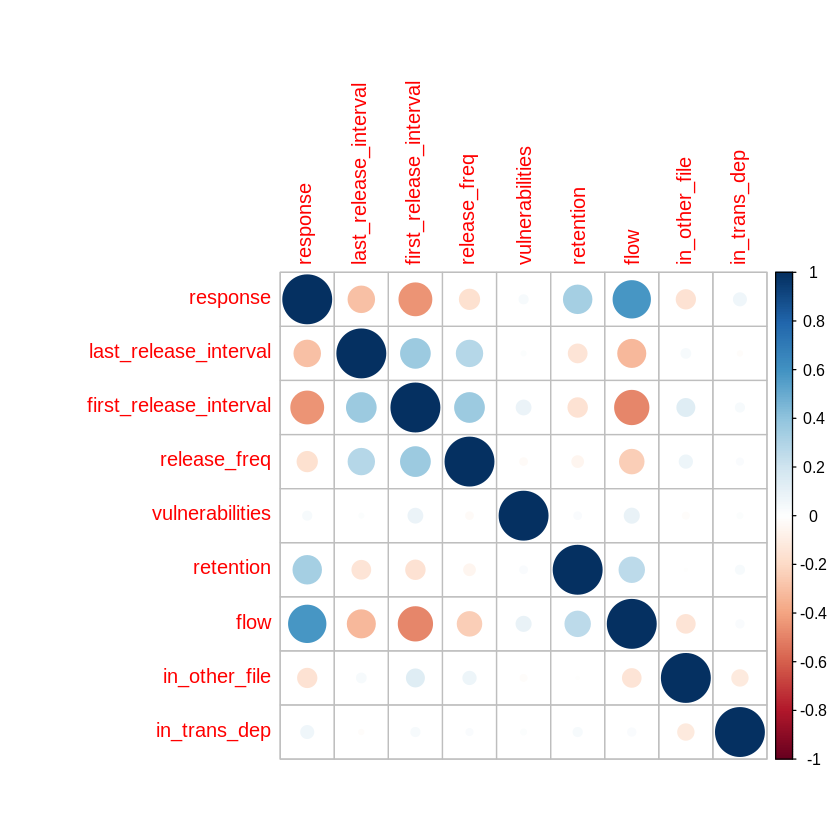

In [5]:
correlations <- cor(data[vars])
corrplot(correlations, method="circle")

In [6]:
# data$license = factor(data$license, ordered = FALSE)
logit <- glm(response ~ last_release_interval + first_release_interval + release_freq + C(license)
             + vulnerabilities + retention + flow + in_other_file + in_trans_dep, 
             data = data, family = "binomial")
summary(logit)

with(logit, null.deviance - deviance)
with(logit, df.null - df.residual)
with(logit, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE))

pR2(logit)

probs <- predict(logit, type = "response")
pred <- ifelse(probs > 0.85, "Add", "Rem")
perf = table(pred, data$response)
perf
diag(sum(diag(perf)) / sum(perf))
paste((perf[[1,2]] + perf[[2,1]]) / sum(perf), (perf[[1,2]] + perf[[2,2]]) / sum(perf))


Call:
glm(formula = response ~ last_release_interval + first_release_interval + 
    release_freq + C(license) + vulnerabilities + retention + 
    flow + in_other_file + in_trans_dep, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6990  -0.6165   0.2682   0.6475   3.4438  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -5.431927   0.185476 -29.286  < 2e-16 ***
last_release_interval  -0.174165   0.012487 -13.947  < 2e-16 ***
first_release_interval -0.178966   0.005212 -34.334  < 2e-16 ***
release_freq            0.050163   0.005259   9.539  < 2e-16 ***
C(license)BSD          -0.005860   0.088396  -0.066  0.94714    
C(license)EPL          -0.022591   0.047192  -0.479  0.63215    
C(license)GPL          -0.170076   0.056987  -2.984  0.00284 ** 
C(license)JSON          0.447092   0.225642   1.981  0.04754 *  
C(license)LGPL          0.641429   0.067639   9.483  < 2e-16 

[1] 17386.05

[1] 16

[1] 0

llh       llhNull            G2      McFadden          r2ML 
-1.550839e+04 -2.420141e+04  1.738605e+04  3.591949e-01  3.919930e-01 
         r2CU 
 5.228423e-01

     
pred      0     1
  Add   700  7114
  Rem 16202 10926

<0 x 0 matrix>

[1] "0.667277202220823 0.516284127983516"

In [13]:
data <- read.csv("cache/model_data_json_r.csv")
#data$license = factor(data$license, ordered = FALSE)
logit <- glm(response ~ last_release_interval + first_release_interval + release_freq + C(license)
             + vulnerabilities + retention + flow + in_other_file + in_trans_dep, 
             data = data, family = "binomial")
summary(logit)
with(logit, null.deviance - deviance)
with(logit, df.null - df.residual)
with(logit, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE))
pR2(logit)
probs <- predict(logit, type = "response")
pred <- ifelse(probs > 0.5, "Add", "Rem")
perf = table(pred, data$response)
perf
diag(sum(diag(perf)) / sum(perf))
paste((perf[[1,2]] + perf[[2,1]]) / sum(perf), (perf[[2,1]] + perf[[2,2]]) / sum(perf))


Call:
glm(formula = response ~ last_release_interval + first_release_interval + 
    release_freq + C(license) + vulnerabilities + retention + 
    flow + in_other_file + in_trans_dep, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7625  -0.3311  -0.0241   0.5006   3.9596  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -8.07459    0.99624  -8.105 5.27e-16 ***
last_release_interval   -0.17908    0.11977  -1.495  0.13485    
first_release_interval  -0.26160    0.03230  -8.099 5.55e-16 ***
release_freq             0.11029    0.03955   2.789  0.00529 ** 
C(license)GPL           -0.56934    0.58673  -0.970  0.33187    
C(license)JSON           1.47124    0.27051   5.439 5.36e-08 ***
C(license)LGPL          -1.04506    0.44492  -2.349  0.01883 *  
C(license)No License    13.98590  286.28843   0.049  0.96104    
C(license)Other          0.97362    0.57448   1.695  0.09012 

[1] 2530.724

[1] 13

[1] 0

llh       llhNull            G2      McFadden          r2ML 
-1054.5981223 -2319.9598786  2530.7235127     0.5454240     0.5305141 
         r2CU 
    0.7073526

     
pred     0    1
  Add  285 1509
  Rem 1391  162

<0 x 0 matrix>

[1] "0.866447564983567 0.463997609799821"

In [8]:
# LGPL is logback, MIT is slf4j
data <- read.csv("cache/model_data_logging_r.csv")
#data$license = factor(data$license, ordered = FALSE)
logit <- glm(response ~ last_release_interval + first_release_interval + release_freq + C(license)
             + vulnerabilities + retention + flow + in_other_file + in_trans_dep, 
             data = data, family = "binomial")
summary(logit)
with(logit, null.deviance - deviance)
with(logit, df.null - df.residual)
with(logit, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE))
pR2(logit)
probs <- predict(logit, type = "response")
pred <- ifelse(probs > 0.5, "Add", "Rem")
perf = table(pred, data$response)
perf
diag(sum(diag(perf)) / sum(perf))
paste((perf[[1,2]] + perf[[2,1]]) / sum(perf), (perf[[2,1]] + perf[[2,2]]) / sum(perf))


Call:
glm(formula = response ~ last_release_interval + first_release_interval + 
    release_freq + C(license) + vulnerabilities + retention + 
    flow + in_other_file + in_trans_dep, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4327  -0.6533   0.3944   0.6613   3.5320  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.18585    0.42258  -2.806 0.005013 ** 
last_release_interval   0.15395    0.05843   2.635 0.008417 ** 
first_release_interval -0.04559    0.01276  -3.572 0.000354 ***
release_freq           -0.31270    0.02941 -10.631  < 2e-16 ***
C(license)LGPL         -0.09515    0.12381  -0.769 0.442146    
C(license)MIT          -0.77120    0.08600  -8.968  < 2e-16 ***
vulnerabilities        -0.55023    0.13856  -3.971 7.15e-05 ***
retention               3.31191    0.48866   6.777 1.22e-11 ***
flow                    1.60890    0.06128  26.256  < 2e-16 ***
in_oth

[1] 4315.109

[1] 10

[1] 0

llh       llhNull            G2      McFadden          r2ML 
-4223.4059197 -6380.9605799  4315.1093206     0.3381238     0.3737248 
         r2CU 
    0.4986806

     
pred     0    1
  Add 1083 4074
  Rem 3307  757

<0 x 0 matrix>

[1] "0.800455482051838 0.440733109207244"

In [9]:
data <- read.csv("cache/model_data_testing_r.csv")
#data$license = factor(data$license, ordered = FALSE)
logit <- glm(response ~ last_release_interval + first_release_interval + release_freq + C(license)
             + vulnerabilities + retention + flow + in_other_file + in_trans_dep, 
             data = data, family = "binomial")
summary(logit)
with(logit, null.deviance - deviance)
with(logit, df.null - df.residual)
with(logit, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE))
pR2(logit)
probs <- predict(logit, type = "response")
pred <- ifelse(probs > 0.5, "Add", "Rem")
perf = table(pred, data$response)
perf
diag(sum(diag(perf)) / sum(perf))
paste((perf[[1,2]] + perf[[2,1]]) / sum(perf), (perf[[2,1]] + perf[[2,2]]) / sum(perf))


Call:
glm(formula = response ~ last_release_interval + first_release_interval + 
    release_freq + C(license) + vulnerabilities + retention + 
    flow + in_other_file + in_trans_dep, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9013  -0.5045   0.2468   0.5797   3.5581  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -5.80886    0.54931 -10.575  < 2e-16 ***
last_release_interval   -0.30951    0.04815  -6.428 1.29e-10 ***
first_release_interval  -0.19461    0.01402 -13.879  < 2e-16 ***
release_freq             0.13924    0.01488   9.361  < 2e-16 ***
C(license)BSD            0.20691    0.22753   0.909 0.363157    
C(license)EPL            0.13457    0.09463   1.422 0.155012    
C(license)GPL           -1.84947    1.42237  -1.300 0.193508    
C(license)MIT            0.44544    0.13256   3.360 0.000778 ***
C(license)No License    10.42761  324.74373   0.032 0.974384 

[1] 3632.888

[1] 14

[1] 0

llh       llhNull            G2      McFadden          r2ML 
-2406.8417015 -4223.2857491  3632.8880952     0.4301021     0.4470278 
         r2CU 
    0.5978057

     
pred     0    1
  Add  540 2874
  Rem 2238  480

<0 x 0 matrix>

[1] "0.833659491193738 0.443248532289628"